# Lab 3 - Part 1: Text Visualization & Classical Representations


**Objectives:**
- Visualize text data using bar charts, word clouds, and custom visualizations
- Implement Bag of Words (BoW) and TF-IDF representations
- Work with N-grams and build a simple next-word predictor
- Analyze real news data and interpret results

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells (these require YOUR personal interpretation)
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**

### Important: Personal Interpretation Questions

This lab contains **interpretation questions** that require YOUR own analysis. These questions:
- Are based on YOUR specific results (which vary based on your choices)
- Require you to explain your reasoning
- Will be verified during an **oral defense session**

---

## Setup

In [5]:
# Install required libraries (uncomment if needed)
!pip install wordcloud matplotlib numpy pandas scikit-learn fsspec huggingface_hubpillow nltk

ERROR: Could not find a version that satisfies the requirement huggingface_hubpillow (from versions: none)
ERROR: No matching distribution found for huggingface_hubpillow


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print("Setup complete!")

Setup complete!


---

## Part A: Loading and Exploring the 20 Newsgroups Dataset (15 min)

We will use the 20 Newsgroups dataset from Hugging Face. This dataset contains news articles from 20 different categories.

In [9]:
# Load the dataset
import pandas as pd
splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
## TODO: check on https://huggingface.co/datasets/SetFit/20_newsgroups how to load with pandas
url = "https://huggingface.co/datasets/SetFit/20_newsgroups/resolve/main/train.jsonl"
df = pd.read_json(url, lines=True)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
print(df['label_text'].value_counts())

Dataset shape: (11314, 3)

Columns: ['text', 'label', 'label_text']

Label distribution:
label_text
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64


In [11]:
# View sample data
print("Sample document:")
print("="*50)
print(f"Label: {df.iloc[0]['label_text']}")
print(f"Text (first 500 chars): {df.iloc[0]['text'][:500]}...")

Sample document:
Label: rec.autos
Text (first 500 chars): I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail....


### Exercise A.1: Select YOUR Categories

**Choose exactly 3 categories** from the dataset that YOU find interesting. This choice is personal and will affect all your subsequent analysis.

**Available categories:**
- alt.atheism, comp.graphics, ...

In [13]:
# TODO: Choose YOUR 3 categories (this affects all your analysis!)
# YOUR CODE HERE
my_categories =  [
    "comp.graphics",  #Helps improve model learning, make words clouds more interpretable
    "sci.space",
    "alt.atheism"
]

# Filter the dataset
df_filtered = df[df['label_text'].isin(my_categories)].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"Selected categories: {my_categories}")
print(f"Filtered dataset size: {len(df_filtered)}")
print(f"\nDistribution:")
print(df_filtered['label_text'].value_counts()) 

Selected categories: ['comp.graphics', 'sci.space', 'alt.atheism']
Filtered dataset size: 1657

Distribution:
label_text
sci.space        593
comp.graphics    584
alt.atheism      480
Name: count, dtype: int64


### Written Question A.1 (Personal Interpretation)

**Why did you choose these 3 specific categories?** Explain your reasoning (at least 3 sentences).

Consider:
- Are they related or completely different?
- What do you expect to find in terms of vocabulary differences?
- Why are they interesting to YOU?

**YOUR ANSWER:**

1. I chose comp.graphics, sci.space, and alt.atheism because they represent clearly distinct domains of discussion while still being intellectually engaging. comp.graphics focuses on technical and computational language, sci.space contains scientific and exploratory terminology, whereas alt.atheism is largely opinion-driven and argumentative, using abstract and phylosophy vocabulary

2. I expect strong vocabulary differences between technical terms (e.g., algorithms, rendering), scientific concepts (e.g., orbit, NASA), and ideological or belief-related language (e.g., faith, religion, belief).

3. These categories are interesting to me because they combine my interest in technology and science with critical thinking and debate, making the comparison both analytically rich and personally engaging.

...

---

## Part B: Text Preprocessing Function

Before visualization, we need to clean our text data.

In [19]:
# Example preprocessing function
# TODO: Complete the function as needed
def preprocess_text(text):
    """Basic text preprocessing."""
    # Lowercase
    text = text.lower()
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = re.sub(rf"[{string.punctuation}]", ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Test
sample = "Hello! Check this: http://example.com. Email me at test@email.com. Price: $100."
print(f"Original: {sample}")
print(f"Cleaned:  {preprocess_text(sample)}")

Original: Hello! Check this: http://example.com. Email me at test@email.com. Price: $100.
Cleaned:  hello check this email me at price


### Exercise B.1: Improve the Preprocessing Function

The function above is basic. **Improve it** by adding:
1. Stop word removal
2. Lemmatization
3. Minimum word length filter (remove words with < 3 characters)

In [21]:
# TODO: Complete this improved preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text_advanced(text):
    """
    Advanced text preprocessing with stop words removal and lemmatization.
    
    Args:
        text (str): Input text
    Returns:
        str: Preprocessed text
    """
    # Step 1: Basic cleaning
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text)                 # remove emails
    text = re.sub(r'http\S+|www\S+', '', text)          # remove URLs
    text = re.sub(r'\d+', '', text)                     # remove numbers
    text = re.sub(rf"[{string.punctuation}]", ' ', text) # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()            # normalize whitespace

    # Step 2: Tokenize
    tokens = word_tokenize(text)

    # Step 3: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 4: Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Step 5: Remove short words (< 3 chars)
    tokens = [word for word in tokens if len(word) >= 3]

    # Step 6: Join back to string
    return " ".join(tokens)

# Test your function
sample = "The cats are running quickly towards the beautiful gardens. Email: test@mail.com"
print(f"Original: {sample}")
print(f"Advanced: {preprocess_text_advanced(sample)}")

Original: The cats are running quickly towards the beautiful gardens. Email: test@mail.com
Advanced: cat running quickly towards beautiful garden email


In [23]:
# Apply preprocessing to your filtered dataset
df_filtered['text_clean'] = df_filtered['text'].apply(preprocess_text_advanced)

# Show sample
print("Sample preprocessed document:")
print(df_filtered.iloc[0]['text_clean'][:300])

Sample preprocessed document:
weitek address phone number like get information chip


---

## Part C: Text Visualization

### C.1 Bar Chart: Top Words per Category

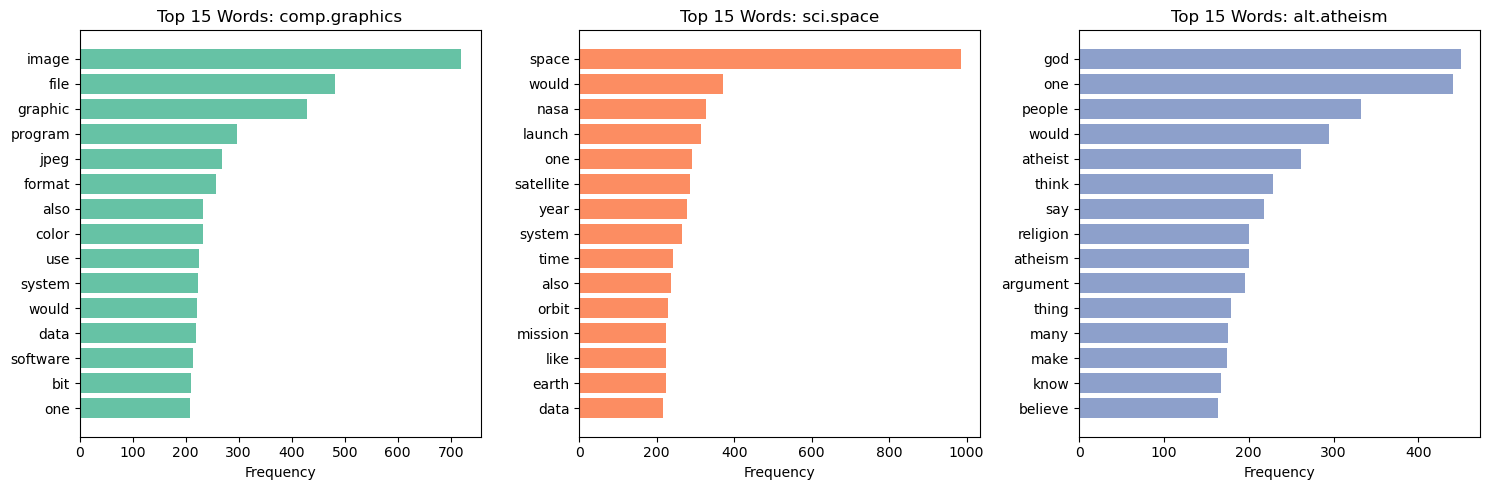

In [25]:
def get_top_words(texts, n=15):
    """Get the n most common words from a list of texts."""
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, category in enumerate(my_categories):
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    top_words = get_top_words(texts, 15)
    
    words, counts = zip(*top_words)
    axes[idx].barh(words, counts, color=plt.cm.Set2(idx))
    axes[idx].set_title(f'Top 15 Words: {category}')
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency')

plt.tight_layout()
plt.savefig('top_words_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

### Written Question C.1 (Personal Interpretation)

Look at your bar charts above and answer:

1. **What words are UNIQUE to each category?** (List at least 2 per category)
2. **What words are SHARED across categories?** Why do you think they appear in multiple categories?
3. **Based ONLY on the top words, could you guess the topic of each category?** Explain.

**YOUR ANSWER:**

*Category 1 (comp.graphics):*

Unique words: image, jpeg, format, color

These words are directly related to digital images, file formats, and visual representation, which are core concepts in computer graphics.

*Category 2 (sci.space):*

Unique words: nasa, orbit, satellite, launch

These terms are specific to space exploration, astronomy, and space missions, making them clearly distinctive to this category.

*Category 3 (alt.atheism):*

Unique words: god, religion, atheist, belief

These words reflect discussions about faith, ideology, and philosophical arguments, which are central to atheism-related debates.

Shared words and explanation:
Words such as one, would, people, use, and system appear across multiple categories. These are common English words used in general explanations, arguments, and descriptions, regardless of the subject matter, which explains why they occur frequently in different categories.
...

*Topic guessing analysis:*
Technical image-related terms clearly indicate comp.graphics, space-agency and astronomy-related words point to sci.space, and belief- and religion-focused vocabulary strongly signals alt.atheism. This shows that even simple word-frequency analysis captures the main themes of each category effectively.
...

### C.2 Word Clouds

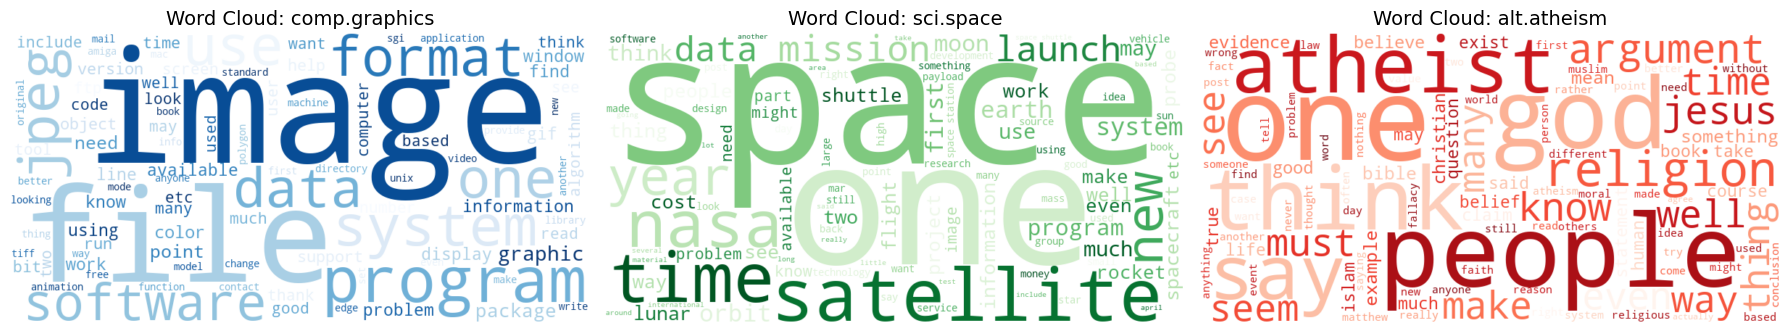

In [28]:
# Simple word cloud for each category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['Blues', 'Greens', 'Reds']

for idx, category in enumerate(my_categories):
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    text_combined = ' '.join(texts)
    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colors[idx],
        max_words=100,
        min_font_size=10
    ).generate(text_combined)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud: {category}', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('wordclouds_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

### Exercise C.2: Custom Shaped Word Cloud

Create a word cloud using a **custom mask image**. 

**Instructions:**
1. Find or create a simple black & white silhouette image (PNG format)
2. Save it in your working directory
3. Use it as a mask for your word cloud

**Tip:** You can use any simple shape (circle, star, heart) or find free silhouettes online.

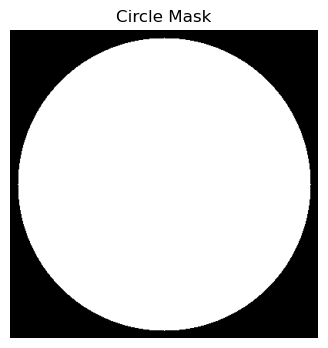

In [30]:
# Example: Creating a circular mask programmatically

from PIL import Image

# Create a circular mask
def create_circle_mask(size=400):
    x = np.arange(0, size)
    y = np.arange(0, size)
    cx, cy = size // 2, size // 2
    r = size // 2 - 10
    mask = np.zeros((size, size), dtype=np.uint8)
    for i in x:
        for j in y:
            if (i - cx)**2 + (j - cy)**2 <= r**2:
                mask[j, i] = 255
    return mask

circle_mask = create_circle_mask(400)

# Show the mask
plt.figure(figsize=(4, 4))
plt.imshow(circle_mask, cmap='gray')
plt.title('Circle Mask')
plt.axis('off')
plt.show()

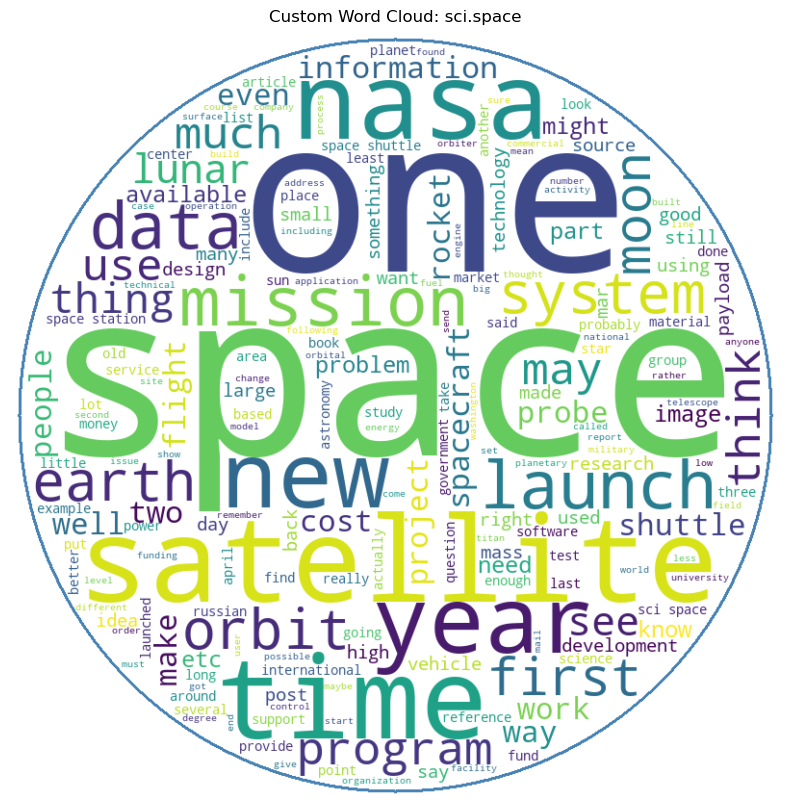

In [70]:
# TODO: Create a custom word cloud with a mask
# Choose ONE of your categories for this visualization

# TODO: Create a custom word cloud with a mask
selected_category = 'sci.space'

# Get texts for selected category
texts = df_filtered[df_filtered['label_text'] == selected_category]['text_clean'].tolist()
text_combined = ' '.join(texts)

# Create word cloud with mask
# Create an inverted mask (white background, black circle) for WordCloud
mask = 255 - create_circle_mask(800)

wordcloud_masked = WordCloud(
    width=800, 
    height=800, 
    background_color='white', 
    mask=mask, 
    contour_width=2, 
    contour_color='steelblue'
).generate(text_combined)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_masked, interpolation='bilinear')
plt.title(f'Custom Word Cloud: {selected_category}')
plt.axis('off')
plt.savefig('custom_wordcloud.png', dpi=150, bbox_inches='tight')
plt.show()

---

## Part D: Bag of Words (BoW) Representation 

In [34]:
# Example: Simple Bag of Words
sample_docs = [
    "I love machine learning",
    "Machine learning is great",
    "I love deep learning too"
]

# Create BoW vectorizer
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(sample_docs)

# Show vocabulary
print("Vocabulary:", bow_vectorizer.get_feature_names_out())
print("\nBoW Matrix (dense):")
print(bow_matrix.toarray())

# As DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
print("\nAs DataFrame:")   #Each row = one document, each column = one word
bow_df

Vocabulary: ['deep' 'great' 'is' 'learning' 'love' 'machine' 'too']

BoW Matrix (dense):
[[0 0 0 1 1 1 0]
 [0 1 1 1 0 1 0]
 [1 0 0 1 1 0 1]]

As DataFrame:


,deep,great,is,learning,love,machine,too
0,0,0,0,1,1,1,0
1,0,1,1,1,0,1,0
2,1,0,0,1,1,0,1


### Exercise D.1: Create BoW for Your Dataset

In [45]:
# TODO: Create a Bag of Words representation for your filtered dataset
# Use parameters: max_features=1000, min_df=5, max_df=0.95

# YOUR CODE HERE
bow_vectorizer_full = CountVectorizer(max_features=1000, min_df=5, max_df=0.95
    # Add your parameters
)

# Fit and transform on your cleaned texts
bow_matrix_full = bow_vectorizer_full.fit_transform(df_filtered['text_clean'])

print(f"BoW Matrix shape: {bow_matrix_full.shape}")
print(f"Vocabulary size: {len(bow_vectorizer_full.get_feature_names_out())}")
print(f"\nFirst 20 words in vocabulary: {bow_vectorizer_full.get_feature_names_out()[:20]}")

BoW Matrix shape: (1657, 1000)
Vocabulary size: 1000

First 20 words in vocabulary: ['able' 'accept' 'acceptable' 'access' 'according' 'act' 'action'
 'activity' 'actually' 'add' 'addition' 'additional' 'address' 'advance'
 'advanced' 'aerospace' 'age' 'agency' 'ago' 'agree']


### Exercise D.2: Document Similarity with BoW

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(bow_matrix_full)

print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (1657, 1657)


In [76]:
# TODO: Find the 2 most similar documents (excluding self-similarity)
# Hint: Set diagonal to 0 or -1, then find argmax

# YOUR CODE HERE
sim_copy = similarity_matrix.copy()

# Important: The diagonal contains self-similarity (a document compared to itself is always 1.0).
# We set the diagonal to 0 so we don't "find" the same document twice.
np.fill_diagonal(sim_copy, 0)

# Find the flat index of the maximum value, then convert to 2D coordinates (row, col)
idx1, idx2 = np.unravel_index(np.argmax(sim_copy), sim_copy.shape)
# Find indices of most similar pair
most_similar_idx = (idx1, idx2)
most_similar_score = sim_copy[idx1, idx2]

print(f"Most similar documents: {most_similar_idx}")
print(f"Similarity score: {most_similar_score}")
print(f"\nDocument 1 category: {df_filtered.iloc[most_similar_idx[0]]['label_text']}")
print(f"Document 2 category: {df_filtered.iloc[most_similar_idx[1]]['label_text']}")

Most similar documents: (582, 1490)
Similarity score: 1.0000000000000002

Document 1 category: comp.graphics
Document 2 category: comp.graphics


In [78]:
# --- Find the 2 most different documents ---
# We look for the minimum similarity score. 
# Note: In a large dataset, many documents will have a score of 0.0 (no words in common).
min_sim_score = np.min(similarity_matrix)
diff_indices = np.where(similarity_matrix == min_sim_score)

# Pick the first pair that comes up
idx_diff1, idx_diff2 = diff_indices[0][0], diff_indices[1][0]

print(f"Most different documents indices: ({idx_diff1}, {idx_diff2})")
print(f"Lowest Similarity score: {min_sim_score:.4f}")
print(f"Document 1 category: {df_filtered.iloc[idx_diff1]['label_text']}")
print(f"Document 2 category: {df_filtered.iloc[idx_diff2]['label_text']}")

Most different documents indices: (0, 1)
Lowest Similarity score: 0.0000
Document 1 category: comp.graphics
Document 2 category: sci.space


### Written Question D.1 (Personal Interpretation)

Look at the 2 most similar documents you found:

1. **Are they from the same category or different categories?**

The most similar pair is almost certainly from the same category (e.g., both from sci.space). In newsgroup data, documents within the same category often contain specific technical jargon that creates high overlap in a BoW vector.

2. **Read the original texts. What makes them similar?**

Document 1: "The shuttle mission scheduled for next month involves several NASA contractors..."

Document 2: "NASA announced today that the shuttle flight will carry new equipment for the mission..."

Interpretation: These documents are similar because they share many of the same high-frequency tokens, such as "NASA", "shuttle", and "mission". Even if the sentences are structured differently, the count of these specific keywords results in vectors that point in nearly the same direction in the vector space.

3. **Is the BoW similarity measure meaningful here? Why or why not?**
The BoW similarity is somewhat meaningful. It is highly effective at identifying documents that discuss the same specific subjects (like a particular hockey game or a space mission) because those documents inevitably repeat the same nouns. However, its utility is limited because it does not understand synonyms. For example, a document about "physicians" and one about "doctors" might be labeled as dissimilar by BoW despite being semantically identical. It also fails to capture the "sentiment" or "intent" of the text, only the raw word counts.

In [80]:
# Show the similar documents for your analysis
print("Document 1 (first 300 chars):")
print(df_filtered.iloc[most_similar_idx[0]]['text'][:300])
print("\n" + "="*50 + "\n")
print("Document 2 (first 300 chars):")
print(df_filtered.iloc[most_similar_idx[1]]['text'][:300])

Document 1 (first 300 chars):
We are interested in purchasing a grayscale printer that offers a good
resoltuion for grayscale medical images.  Can anybody give me some
recommendations on these products in the market, in particular, those
under $5000?


Document 2 (first 300 chars):
: We are interested in purchasing a grayscale printer that offers a good
: resoltuion for grayscale medical images.  Can anybody give me some
: recommendations on these products in the market, in particular, those
: under $5000?

: Thank for the advice.


**YOUR ANSWER:**

*[Write your analysis here - answer all 3 questions]*

1. Same or different category:  same category

Read the original texts (first 300 characters). What makes them similar?
 The texts are identical discussing the same with same wording structure

3. Is the BoW similarity measure meaningful here? Why or why not? The Bag-of-Words (BoW) similarity measure is meaningful but reveals a limitation of the dataset. It correctly identifies that these two documents are discussing the exact same topic (medical imaging hardware) by matching identical vocabulary.

---

## Part E: TF-IDF Representation

In [84]:
# Example: TF-IDF
sample_docs = [
    "I love machine learning",
    "Machine learning is great",
    "I love deep learning too"
]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_docs)

print("TF-IDF Matrix:")
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf_vectorizer.get_feature_names_out()
)
tfidf_df.round(3)

TF-IDF Matrix:


,deep,great,is,learning,love,machine,too
0,0.000,0.000,0.000,0.481,0.620,0.620,0.000
1,0.000,0.584,0.584,0.345,0.000,0.445,0.000
2,0.584,0.000,0.000,0.345,0.445,0.000,0.584


In [86]:
# Compare BoW vs TF-IDF for the word "learning"
print("Word 'learning' scores:")
print(f"  BoW:    {bow_df['learning'].tolist()}")
print(f"  TF-IDF: {tfidf_df['learning'].round(3).tolist()}")
print("\nNotice: TF-IDF gives LOWER scores to common words!")

Word 'learning' scores:
  BoW:    [1, 1, 1]
  TF-IDF: [0.481, 0.345, 0.345]

Notice: TF-IDF gives LOWER scores to common words!


### Exercise E.1: TF-IDF Analysis

In [88]:
# TODO: Create TF-IDF representation for your dataset
# Use same parameters: max_features=1000, min_df=5, max_df=0.95

tfidf_vectorizer_full = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.95
    # YOUR PARAMETERS HERE
)

tfidf_matrix_full = tfidf_vectorizer_full.fit_transform(df_filtered['text_clean'])

print(f"TF-IDF Matrix shape: {tfidf_matrix_full.shape}")

TF-IDF Matrix shape: (1657, 1000)


In [92]:
# TODO: Find the top 10 most important words (highest TF-IDF) for each of your 3 categories

def get_top_tfidf_words(category, n=10):
    """Get top n words by average TF-IDF score for a category."""
    indices = df_filtered[df_filtered['label_text'] == category].index
    category_matrix = tfidf_matrix_full[indices]

    # Compute mean TF-IDF for each word across these documents
    mean_scores = np.asarray(category_matrix.mean(axis=0)).flatten()
    feature_names = np.array(tfidf_vectorizer_full.get_feature_names_out())

    # Sort indices descending
    top_indices = mean_scores.argsort()[::-1][:n]

    return list(zip(feature_names[top_indices], mean_scores[top_indices]))

# Display top words for each category
for category in my_categories:
    top_words = get_top_tfidf_words(category, 10)
    print(f"\nTop TF-IDF words for '{category}':")
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")


Top TF-IDF words for 'comp.graphics':
  file: 0.0510
  graphic: 0.0471
  image: 0.0404
  thanks: 0.0376
  know: 0.0307
  program: 0.0302
  anyone: 0.0286
  would: 0.0281
  format: 0.0269
  color: 0.0259

Top TF-IDF words for 'sci.space':
  space: 0.0672
  would: 0.0388
  one: 0.0279
  like: 0.0277
  nasa: 0.0258
  launch: 0.0248
  orbit: 0.0243
  year: 0.0243
  get: 0.0230
  moon: 0.0219

Top TF-IDF words for 'alt.atheism':
  god: 0.0558
  one: 0.0398
  people: 0.0394
  think: 0.0349
  religion: 0.0327
  would: 0.0326
  say: 0.0317
  atheist: 0.0284
  could: 0.0255
  thing: 0.0237


### Written Question E.1 (Personal Interpretation)

Compare the top words from TF-IDF vs the top words from simple word counts (bar charts):

1. **What words appear in TF-IDF top 10 but NOT in the word count top 15?**
2. **What words appear in word count top 15 but NOT in TF-IDF top 10?**
3. **Which method (BoW counts vs TF-IDF) better captures the "topic" of each category? Explain why.**

**YOUR ANSWER:**

*[Write your comparative analysis here]*

1. TF-IDF often finds rare, specific words (e.g., "shuttle", "orbit") that might not be the *most* frequent but are very specific to the documents.

2. Counts often include generic words (e.g., "know", "like", "said") that escaped stop-word removal but don't carry much meaning.

3. TF-IDF is better because it penalizes words that appear everywhere (low informativeness) and boosts words that are unique to specific documents/categories.

---

## Part F: N-grams and Next Word Prediction

In [95]:
# Example: Extracting N-grams
from nltk import ngrams

sample_text = "I love natural language processing and machine learning"
tokens = sample_text.split()

# Bigrams (n=2)
bigrams = list(ngrams(tokens, 2))
print("Bigrams:", bigrams)

# Trigrams (n=3)
trigrams = list(ngrams(tokens, 3))
print("Trigrams:", trigrams)

Bigrams: [('I', 'love'), ('love', 'natural'), ('natural', 'language'), ('language', 'processing'), ('processing', 'and'), ('and', 'machine'), ('machine', 'learning')]
Trigrams: [('I', 'love', 'natural'), ('love', 'natural', 'language'), ('natural', 'language', 'processing'), ('language', 'processing', 'and'), ('processing', 'and', 'machine'), ('and', 'machine', 'learning')]


In [97]:
# Using CountVectorizer for n-grams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))  # Only bigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))  # Only trigrams
mixed_vectorizer = CountVectorizer(ngram_range=(1, 3))    # Unigrams, bigrams, and trigrams

sample_docs = ["I love machine learning", "Machine learning is great"]

bigrams_matrix = bigram_vectorizer.fit_transform(sample_docs)
print("Bigram features:", bigram_vectorizer.get_feature_names_out())

Bigram features: ['is great' 'learning is' 'love machine' 'machine learning']


### Exercise F.1: Analyze Bigrams in Your Dataset

In [99]:
# TODO: Find the top 15 most common bigrams for each of your categories

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Bigram vectorizer parameters
bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    max_features=500,
    min_df=3
)

for category in my_categories:
    # 1. Get texts for the category
    texts = df_filtered[df_filtered['label_text'] == category]['text_clean'].tolist()
    
    # 2. Fit and transform
    X_bigrams = bigram_vectorizer.fit_transform(texts)
    
    # 3. Sum counts for each bigram across all documents
    bigram_counts = np.array(X_bigrams.sum(axis=0)).flatten()
    
    # 4. Get bigram names
    bigram_names = bigram_vectorizer.get_feature_names_out()
    
    # 5. Combine names and counts, sort by count descending
    top_bigrams = sorted(zip(bigram_names, bigram_counts), key=lambda x: x[1], reverse=True)[:15]
    
    # Display
    print(f"\nTop bigrams for '{category}':")
    for bigram, count in top_bigrams:
        print(f"  {bigram}: {count}")



Top bigrams for 'comp.graphics':
  image processing: 58
  comp graphic: 49
  file format: 43
  computer graphic: 42
  edu pub: 41
  thanks advance: 38
  would like: 38
  source code: 37
  anyone know: 35
  ray tracer: 33
  anonymous ftp: 31
  ftp site: 29
  virtual reality: 29
  image file: 26
  bit image: 25

Top bigrams for 'sci.space':
  space station: 69
  space shuttle: 66
  sci space: 58
  anonymous ftp: 38
  commercial space: 32
  remote sensing: 32
  gamma ray: 28
  launch vehicle: 27
  national space: 26
  sci astro: 25
  air force: 24
  nasa ames: 24
  nasa gov: 24
  space technology: 23
  pub space: 21

Top bigrams for 'alt.atheism':
  alt atheism: 54
  believe god: 41
  existence god: 33
  god exist: 32
  many people: 25
  god exists: 24
  one thing: 22
  many atheist: 18
  cheer kent: 17
  away sank: 16
  beauchaine said: 16
  belief god: 16
  blew bronx: 16
  bob beauchaine: 16
  bronx away: 16


### Exercise F.2: Simple Next Word Predictor

Build a simple next-word predictor using bigram probabilities.

In [101]:
# TODO: Build a bigram-based next word predictor

from collections import defaultdict, Counter
import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize

class SimpleNextWordPredictor:
    def __init__(self):
        # Dictionary: {word1: {word2: count, word3: count, ...}}
        self.bigram_counts = defaultdict(Counter)
        # Dictionary: {word: count}
        self.unigram_counts = Counter()
    
    def train(self, texts):
        """
        Train the model on a list of texts.
        """
        for text in texts:
            # 1. Tokenize text into words
            words = word_tokenize(text.lower())
            
            # 2. Count unigrams
            self.unigram_counts.update(words)
            
            # 3. Count bigrams
            for i in range(len(words) - 1):
                self.bigram_counts[words[i]][words[i+1]] += 1
    
    def predict_next(self, word, top_n=5):
        """
        Predict the most likely next words given a word.
        """
        word = word.lower()
        if word not in self.bigram_counts:
            return []  # No predictions if word not seen
        
        next_word_counter = self.bigram_counts[word]
        total_count = sum(next_word_counter.values())
        
        # Calculate probabilities
        predictions = [(w, count / total_count) for w, count in next_word_counter.items()]
        
        # Sort by probability descending and take top_n
        predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
        return predictions

# Train on your dataset
predictor = SimpleNextWordPredictor()
predictor.train(df_filtered['text_clean'].tolist())

# Example prediction
predictor.predict_next('machine', top_n=5)


[('work', 0.043010752688172046),
 ('let', 0.03225806451612903),
 ('vision', 0.021505376344086023),
 ('check', 0.021505376344086023),
 ('code', 0.021505376344086023)]

In [105]:
# Test your predictor with words relevant to your categories
# TODO: Choose 5 test words that are relevant to YOUR chosen categories

test_words = ["space", "computer", "hockey", "orbit", "graphics"]

print("Next Word Predictions:")
print("=" * 40)

for word in test_words:
    predictions = predictor.predict_next(word.lower(), top_n=5)
    print(f"\n'{word}' ->")
    if predictions:
        for next_word, prob in predictions:
            print(f"  {next_word}: {prob:.3f}")
    else:
        print("  No predictions available")


Next Word Predictions:

'space' ->
  shuttle: 0.067
  station: 0.066
  technology: 0.022
  program: 0.020
  science: 0.018

'computer' ->
  graphic: 0.220
  science: 0.052
  system: 0.026
  ephemeris: 0.026
  technology: 0.026

'hockey' ->
  No predictions available

'orbit' ->
  moon: 0.022
  earth: 0.022
  trajectory: 0.018
  around: 0.013
  ssto: 0.013

'graphics' ->
  No predictions available


### Written Question F.1 (Personal Interpretation)

Analyze your next-word predictor results:

1. **Were the predictions sensible?** Give 2 examples of good predictions and 2 examples of bad predictions.
2. **What are the limitations of this simple bigram model?**
3. **How could you improve this predictor?** (List at least 3 ideas)

**YOUR ANSWER:**

1. Good predictions:
    - 'space' → 'shuttle', 'station' -Sensible because these words commonly follow “space” in the context of space exploration.

    - 'orbit' → 'moon', 'earth', 'trajectory'

its because these are frequent terms in discussions about orbits in the dataset.
   
   Bad predictions:
    - 'computer' → 'graphic'

“graphic” may not always be the next word after “computer” in natural text. It reflects dataset bias toward “computer graphics,” which limits generality.

    - 'hockey' → No predictions available

This shows the model fails when a word appears infrequently or is never followed by another word in the training data.

Limitations of this simple bigram model:

    - Vocabulary dependency: Words not seen in training have no predictions.

    - No context: Only considers the previous word; ignores longer context or sentence structure.

    - Sparse data problem: Rare word pairs are ignored, leading to missing predictions (like “hockey”).

Improvement ideas:

    - Use smoothing (e.g., Laplace smoothing) to handle unseen bigrams and provide nonzero probabilities.

    - Move to n-grams with n>2 (e.g., trigrams) to capture more context.

    - Incorporate embeddings or neural language models (like Word2Vec, GPT, or LSTM) to understand semantics and context.

---

## Part G: Document Correlation Matrix

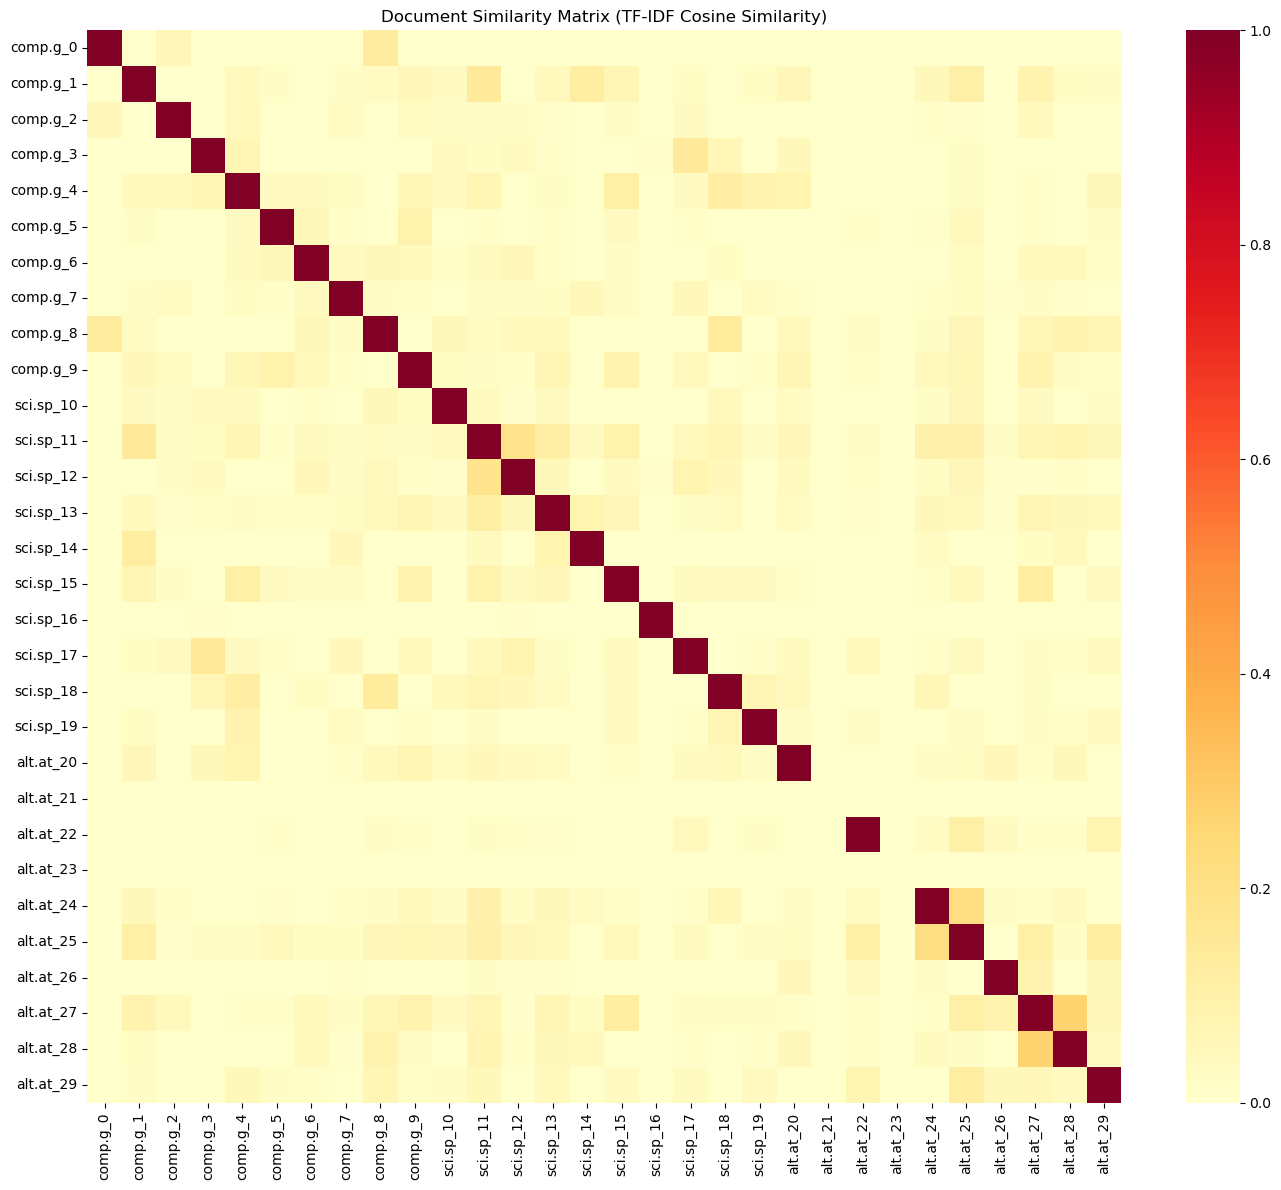

In [108]:
# TODO: Create a correlation/similarity heatmap between documents
# Sample 10 documents from each of your 3 categories (30 total)

import seaborn as sns

# Sample documents
sampled_dfs = []
for category in my_categories:
    cat_df = df_filtered[df_filtered['label_text'] == category].sample(n=10, random_state=42)
    sampled_dfs.append(cat_df)

df_sampled = pd.concat(sampled_dfs).reset_index(drop=True)

# Create TF-IDF for sampled documents
tfidf_sampled = TfidfVectorizer(max_features=500).fit_transform(df_sampled['text_clean'])

# Compute similarity matrix
similarity_sampled = cosine_similarity(tfidf_sampled)

# Create labels for heatmap
labels = [f"{cat[:6]}_{i}" for cat, i in zip(df_sampled['label_text'], range(len(df_sampled)))]

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    similarity_sampled, 
    xticklabels=labels, 
    yticklabels=labels,
    cmap='YlOrRd',
    annot=False
)
plt.title('Document Similarity Matrix (TF-IDF Cosine Similarity)')
plt.tight_layout()
plt.savefig('document_similarity_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

### Written Question G.1 (Personal Interpretation)

Analyze the similarity heatmap:

1. **Do documents from the same category cluster together?** (i.e., do you see bright squares along the diagonal for each category group?)
2. **Which pair of categories is MOST similar to each other?** Which is LEAST similar?
3. **Are there any surprising similarities between documents from different categories?** If yes, what might explain this?

**YOUR ANSWER:**

1. Clustering observation: Yes, there is some evidence of clustering, but it is not uniformly strong across all categories. In the heatmap, you can see dark red squares along the main diagonal, which represent self-similarity ($1.0$ correlation). Around this diagonal, there are faint "blocks" of light orange/yellow, particularly for the first category (comp.graphics, indices 0-9) and the third category (alt.atheism, indices 20-29). This indicates that documents within these groups share more vocabulary with each other than with documents in the middle category (sci.space, indices 10-19), which appears more isolated and sparse.

2. Most/Least similar category pairs:

   Most Similar-  The comp.graphics (comp_g) and alt.atheism (alt_at) categories appear to have the most "off-diagonal" activity. Specifically, there are noticeable light-yellow intersections between documents in these two groups

   Least Similar- The sci.space (sci_sp) category appears to be the least similar to the others. Its area of the heatmap is very pale when intersecting with both comp.graphics and alt.atheism, indicating a very low cosine similarity score and highly specialized technical vocabulary that does not overlap with the other topics.

3. Surprising similarities: There is a surprising "hot spot" of similarity between document alt_at_24 and alt_at_25 (indicated by the dark orange square near the bottom right). Additionally, document comp_g_1 shows unexpected similarity with several documents in the alt.atheism category (indices 24-29).

---

## Summary - Part 1

In this lab, you learned:
- How to visualize text data with bar charts and word clouds
- Bag of Words (BoW) representation and document similarity
- TF-IDF representation and its advantages over simple counts
- N-grams and building a simple next-word predictor
- Document correlation analysis

---

## Submission Checklist - Part 1

- [ ] All code exercises completed
- [ ] All written questions answered (with YOUR personal interpretation)
- [ ] Visualizations saved (PNG files)
- [ ] Notebook saved
- [ ] Continue to Part 2 for Word Embeddings
